# This notebook is useful once you have chosen your set of parameters in order to evaluate it

In [1]:
#Imports

import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from tensorflow import keras
from keras import layers

from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing as sk

import helper_functions as hf

from analysis_tools import *

CURDIR = os.getcwd()
DATADIR = os.path.join(CURDIR,  "data")
FIGDIR = os.path.join(CURDIR,  "figure")

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
## Let's choose your parameters

#Default values are our best parameters


#process data
type_of_data = 'Price' #'All'
add_return = False
add_log_functions = False
drop_higly_correlated_data = True
add_analysed_curves = True
scaler, feature_range = sk.MinMaxScaler, (0,1)

# params model rnn
rnn_size = 10
size_train = 2000
size_valid = 800
size_test = 3544 - size_train - size_valid
target_id = 0
type_of_rnn = 'GRU'
nb_layers = 1
nb_units = [128]
learning_rate = 0.001
optimizer = keras.optimizers.Adam
loss = keras.losses.MeanSquaredError()
batch_size = 8
epochs = 120

# Import Data

Here, we load data into a Pandas DataFrame

In [3]:
df_blockchain = pd.read_csv(os.path.join(DATADIR, "df_blockchain.csv"),  # Load data
                            delimiter=",")

In [4]:
# nettoyer les datas
index_with_nan = df_blockchain.index[df_blockchain.isnull().any(axis=1)]
df_blockchain.drop(index_with_nan,0, inplace=True)

<ipython-input-4-40ba93a737d2>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_blockchain.drop(index_with_nan,0, inplace=True)


In [5]:
if add_log_functions: # Si on veut ajouter les données passées au log
    df_blockchain['market-price'] = np.log(df_blockchain['market-price'])

In [6]:
if type_of_data == 'Price':
    if add_analysed_curves:
        df = df_blockchain["market-price"]
        ma1_2 = deltamma(df, 20, 50)
        macd1, macd2, macd3 = macd(df, .75, 12, 26)
        boll = bollinger(df, 20, 2)
        new_val = []
        for i in [ma1_2, macd1, macd3, boll]:
            for j in i.columns:
                new_val.append(j)
        macd1 = macd1[50 - 26:]
        macd2 = macd2[50 - 26 - 9:]
        macd3 = macd3[50 - 26 - 9:]
        boll = boll[50 - 20:]
        df_blockchain = df_blockchain[50:]
        macd1.reset_index(inplace=True)
        macd2.reset_index(inplace=True)
        macd3.reset_index(inplace=True)
        boll.reset_index(inplace=True)
        df_blockchain.reset_index(inplace=True)
        df_blockchain = pd.concat([df_blockchain, ma1_2, macd1, macd3, boll], axis=1)

        columns = ["market-price"]+new_val
        dataset = df_blockchain[columns]
    else:
        columns = ['market-price']
        dataset = df_blockchain[columns]

if type_of_data == 'All':
    if add_analysed_curves:
        df = df_blockchain['market-price']
        ma1_2 = deltamma(df, 20, 50)
        macd1, macd2, macd3 = macd(df, .75, 12, 26)
        boll = bollinger(df, 20, 2)
        new_val = []
        for i in [ma1_2, macd1, macd3, boll]:
            for j in i.columns:
                new_val.append(j)
        macd1 = macd1[50 - 26:]
        macd2 = macd2[50 - 26 - 9:]
        macd3 = macd3[50 - 26 - 9:]
        boll = boll[50 - 20:]
        df_blockchain = df_blockchain[50:]
        macd1.reset_index(inplace=True)
        macd2.reset_index(inplace=True)
        macd3.reset_index(inplace=True)
        boll.reset_index(inplace=True)
        df_blockchain.reset_index(inplace=True)
        df_blockchain = pd.concat([df_blockchain, ma1_2, macd1, macd3, boll], axis=1)

        if drop_higly_correlated_data:
            columns = ["market-price","n-transactions-per-block","hash-rate","difficulty","miners-revenue","trade-volume","blocks-size","avg-block-size","transaction-fees","transaction-fees-usd","cost-per-transaction-percent","cost-per-transaction","n-transactions","n-transactions-total","n-transactions-excluding-popular","estimated-transaction-volume-usd","total-bitcoins","market-cap"]
            columns = columns + new_val
            dataset = df_blockchain[columns]   
        else:
            columns = list(df_blockchain.columns)[1:] + new_val
            dataset = df_blockchain[columns]
    else:
        if drop_higly_correlated_data:
            columns = ["market-price","n-transactions-per-block","hash-rate","difficulty","miners-revenue","trade-volume","blocks-size","avg-block-size","transaction-fees","transaction-fees-usd","cost-per-transaction-percent","cost-per-transaction","n-transactions","n-transactions-total","n-transactions-excluding-popular","estimated-transaction-volume-usd","total-bitcoins","market-cap"]
            dataset = df_blockchain[columns]   
        else:
            columns = list(df_blockchain.columns)[1:]
            dataset = df_blockchain[columns]

In [7]:
if add_return:
    col = dataset['market-price'].diff().iloc[1:]
    col[0] = 0
    dataset['ret'] = col
    columns.append('ret')
    

In [8]:
# On nettoie les colonnes si nécessaire
try:
    dataset.drop(columns='index', inplace=True)
except:
    pass
try:
    dataset.drop(columns='Date', inplace=True)
except:
    pass


for i,x in enumerate(columns):
    if x == 'index' or x == 'Date':
        columns.pop(i)


index_with_nan = dataset.index[dataset.iloc[:,1].isnull()]
dataset.drop(index_with_nan,0, inplace=True)

<ipython-input-8-bada5b9cf9aa>:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset.drop(index_with_nan,0, inplace=True)
<ipython-input-8-bada5b9cf9aa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(index_with_nan,0, inplace=True)


In [9]:
dataset.head() # colonnes utilisées pour train le modèle

,market-price,MA20_50,MACD12_26,MACDH,BOLL20_2+,BOLL20_2-,BOLLWDTH20_2
0,3.41,-1.1504,0.006913,0.026179,4.331855,2.368145,1.963711
1,3.28,-1.1290,0.009878,0.021620,4.166560,2.437440,1.729120
2,3.22,-1.1118,0.007341,0.012671,4.044247,2.477753,1.566494
3,3.17,-1.0973,0.004849,0.006035,3.925326,2.517674,1.407652
4,3.04,-1.0841,0.003868,0.002638,3.824380,2.548620,1.275760


# Data scaling

In [10]:
scaler = scaler(feature_range=feature_range)  # On normalise les données pour améliorer l'apprentissage
dataset = scaler.fit_transform(dataset.values.reshape(-1,len(columns)))


# Process data (Making sequences)


In [11]:
data_train = dataset[:size_train]
data_valid = dataset[size_train:size_train+size_valid]
data_test = dataset[size_train+size_valid:size_train+size_valid+size_test]

In [12]:
def process_data(data, rnn_size=rnn_size, target_id=target_id, columns_size=len(columns)):
    X = []
    y = []
    for i in range(len(data)-rnn_size):
        X.append(data[i:i+rnn_size,:])
        y.append(data[i+rnn_size,target_id])
    return np.array(X).astype(np.float32).reshape((-1,rnn_size,columns_size)), np.array(y).astype(np.float32)

In [13]:
# process data for RNN
X_train, y_train = process_data(data_train, rnn_size)
X_val, y_val = process_data(data_valid, rnn_size)
X_test, y_test = process_data(data_test, rnn_size)

# Deep Learning Model


In [14]:
callback= keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,  #allows us to keep the best weights after training the model
    patience=15,
    verbose=0,
    mode="auto",
    restore_best_weights = True)

if type_of_rnn == 'LSTM':
    regressor = keras.Sequential()
    regressor.add(
        keras.layers.Bidirectional(  # We use bidirectional layer
            keras.layers.LSTM(
                units = nb_units[0],
                input_shape = (X_train.shape[1],X_train.shape[2] )
            )
        )
    )
    for i in range(1,nb_layers): # add nb_layers layers
        regressor.add(keras.layers.Dense(units = nb_units[i]))
    regressor.add(keras.layers.Dense(units = 1))
    
    opt = optimizer(learning_rate=learning_rate)
    #Compiling the Recurrent Neural Network with adam optimier and 'mean_absolute_error' as loss function
    regressor.compile(loss=loss, optimizer=opt)
else:
    regressor = keras.Sequential()
    regressor.add(
        keras.layers.Bidirectional(   # We use bidirectional layer
            keras.layers.GRU(
                units = nb_units[0],
                input_shape = (X_train.shape[1],X_train.shape[2] )
            )
        )
    )
    for i in range(1,nb_layers):
        regressor.add(keras.layers.Dense(units = nb_units[i]))
    regressor.add(keras.layers.Dense(units = 1))
    
    opt = optimizer(learning_rate=learning_rate)
    #Compiling the Recurrent Neural Network with the chosen optimier and the chosen norm as loss function
    regressor.compile(loss=loss, optimizer=opt)


In [15]:
history = regressor.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = batch_size, epochs = epochs, callbacks=[callback])

Epoch 1/120
249/249 [==============================] - 7s 9ms/step - loss: 2.6175e-04 - val_loss: 3.8530e-04
Epoch 2/120
249/249 [==============================] - 1s 6ms/step - loss: 1.4583e-06 - val_loss: 3.3559e-04
Epoch 3/120
249/249 [==============================] - 2s 6ms/step - loss: 1.7866e-06 - val_loss: 3.1733e-04
Epoch 4/120
249/249 [==============================] - 2s 6ms/step - loss: 1.4560e-06 - val_loss: 2.7727e-04
Epoch 5/120
249/249 [==============================] - 2s 7ms/step - loss: 1.4025e-06 - val_loss: 2.5069e-04
Epoch 6/120
249/249 [==============================] - 2s 7ms/step - loss: 2.7112e-06 - val_loss: 2.1493e-04
Epoch 7/120
249/249 [==============================] - 2s 7ms/step - loss: 1.7097e-06 - val_loss: 1.8854e-04
Epoch 8/120
249/249 [==============================] - 2s 7ms/step - loss: 2.4965e-06 - val_loss: 1.7284e-04
Epoch 9/120
249/249 [==============================] - 2s 7ms/step - loss: 2.8562e-06 - val_loss: 1.6227e-04
Epoch 10/120
249/24

# Evaluation

In [16]:
y_pred = regressor.predict(X_test) # make the prediction

22/22 [==============================] - 1s 4ms/step


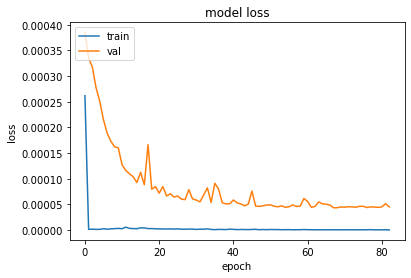

In [17]:
plt.plot(history.history['loss']) # Let's check that the loss converges
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
# compute rmse for test
y_pred_inverse = scaler.inverse_transform(np.concatenate([y_pred, data_test[-len(y_pred):,1:]], axis=1))
y_test_inverse = scaler.inverse_transform(data_test.reshape(-1,len(columns)))[rnn_size:]
if add_log_functions:
    y_pred_inverse = np.exp(y_pred_inverse)
    y_test_inverse = np.exp(y_test_inverse)
rmse_score = np.sqrt(np.square(np.subtract(y_pred_inverse, y_test_inverse)).mean())
print("rmse score : ", rmse_score)


rmse score :  464.6577124139808


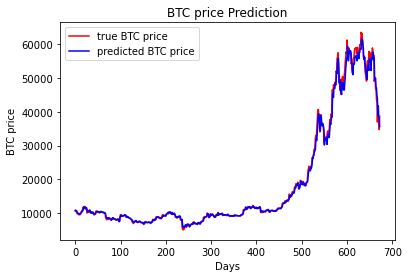

In [19]:
#Graphs for predicted values
t0, t1 = 0, 800
plt.plot(y_test_inverse[:,0][t0:t1], color = 'red', label = 'true BTC price')
plt.plot(y_pred_inverse[:,0][t0:t1], color = 'blue', label = 'predicted BTC price')
plt.title('BTC price Prediction')
plt.xlabel('Days')
plt.ylabel('BTC price')
plt.legend()
plt.show()

# Performances


### Multi_pred permet de moyenner les prédictions de différents modèles pour tenter de gagner en précision 

In [20]:
def multi_pred(models, X_test):
    predictions = []
    for m in models:
        y = m.predict(X_test)
        predictions.append(scaler.inverse_transform(np.concatenate([y, data_test[-len(y):,1:]], axis=1)))
    predictions = np.array(predictions)
    return np.mean(predictions, axis=0)

In [21]:
y_mean_pred_inverse = multi_pred([regressor], X_test) # Ici un seul modèle lui est donné (celui que l'on vient d'entrainer)
y_test_inverse = scaler.inverse_transform(data_test.reshape(-1,len(columns)))[rnn_size:]

22/22 [==============================] - 0s 3ms/step


# Long/Short signals 1

### action_vect1 permet de renvoyer l'action choisie au jour i : 1 = on achète, -1 = on vend, 0 = on ne fait rien

en particulier, cette fonction prend en compte le retard de nos modèles par rapport au cours réel

In [22]:
thr, lag = 25, 10
pred, true = y_mean_pred_inverse[:,0], y_test_inverse[:,0]

def act_vect1(thr, lag):
    action = lag*[0]
    for i in range(lag, len(pred)):
        if pred[i] + thr < true[i] and all(pred[j] > thr +true[j] for j in range(i-lag, i)):
            action.append(1)
        elif pred[i] > thr + true[i] and all(pred[j] + thr < true[j] for j in range(i-lag, i)):
            action.append(-1)
        else:
            action.append(0)
    return action

action1, action2, action3, action4 = act_vect1(0, 1), act_vect1(thr, 1), act_vect1(0, lag), act_vect1(thr, lag)

def scatters(act): # retourne les points à placer sur la courbe, les différents indicateurs d'achat ou de vente
    buy_ax, buy_ord, sell_ax, sell_ord = [], [], [], []
    lag = len(true) - len(act)
    for i in range(len(act)):
        if act[i] == 1:
            buy_ax.append(i + lag), buy_ord.append(true[i + lag])
        if act[i] == -1:
            sell_ax.append(i + lag), sell_ord.append(true[i + lag])
    return buy_ax, buy_ord, sell_ax, sell_ord

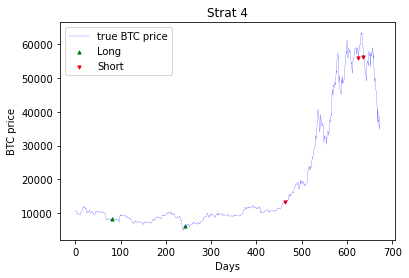

In [23]:
buy_ax, buy_ord, sell_ax, sell_ord = scatters(action4)

plt.plot(y_test_inverse[:,0], color = 'blue', label = 'true BTC price', linewidth=.2)
# plt.plot(y_pred_inverse[:,0], color = 'blue', label = 'predicted BTC price')
plt.scatter(buy_ax, buy_ord, label = 'Long', marker="^", c="green", s=10)
plt.scatter(sell_ax, sell_ord, label = 'Short', marker="v", c="red", s=10)
plt.title('Strat 4')
plt.xlabel('Days')
plt.ylabel('BTC price')
plt.legend()
plt.show()

In [24]:
capital = 10000 # en dollars

In [25]:
##
def choice_t(pred, last_price, thr): #permet de renvoyer l'action choisie au jour i : 1 = on achète, -1 = on vend, 0 = on ne fait rien

    '''
    - pred : float coresponding to the expected value of the price at time t+1

    - float : price at time t  

    - thr : threshold determining what action we decide
    
    '''

    diff = pred - last_price

    if abs(diff) < thr:
        return 0

    else:
        return np.sign(diff)

In [26]:
def evolution3(t1, t2, pred, price, capital_init, frac_b, frac_s, thr): # Autre stratégie, utilisée pour des modèles plus précis
    capital = [capital_init]
    history = [0]
    btc = [0]
    for t in range(t1,t2+1):
        choice = choice_t(pred[t+1], price[t], thr)
        if choice == 0:
            history.append(0)
            capital.append(capital[-1])
            btc.append(btc[-1])
        if choice == 1:
            history.append(1)
            capital.append(capital[-1]*(1-frac_b))
            btc.append(capital[-2]*frac_b/price[t]+btc[-1])
        if choice == -1:
            history.append(-1)
            btc.append((1-frac_s)*btc[-1])
            capital.append(capital[-1]+frac_s*btc[-2]*price[t])

    return history, capital, btc
            



In [27]:
thr = 500 # seuil de décision

In [28]:
pred = y_pred_inverse[:,0]
true = y_test_inverse[:,0]

In [29]:
hist, cap, btc =evolution3(0,600, pred, true, 10000, 0.3, 0.5, thr)

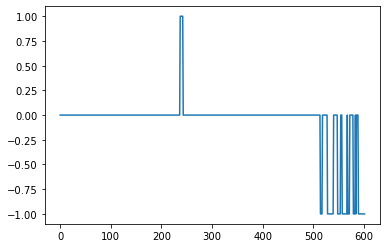

In [30]:
plt.plot(hist)
plt.xlabel('time')
plt.ylabel('choix d achat ou de vente')

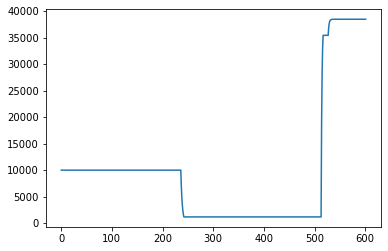

In [31]:
plt.plot(cap)
plt.xlabel('time')
plt.ylabel('Capital')

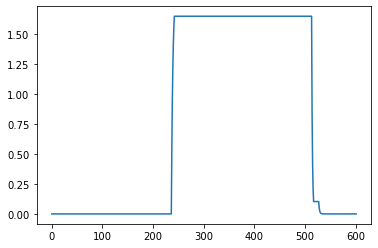

In [32]:
plt.plot(btc)
plt.xlabel('time')
plt.ylabel('Nombre de bitcoins')

In [38]:
total = btc[-1]*true[50] + cap[-1] # calcul de la valorisation de notre porte feuille à la fin de la fenêtre de prédiction
print(f'Nous avons a la fin de la prédiction obtenu : {round(total, 2)} $')

Nous avons a la fin de la prédiction obtenu : 38480.31 $
